In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

In [2]:
path = "../LASER/B-1/"
filename = lambda x: path + "B-1_DoubleSlit_" + str(x) + ".csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(V)"
MILIVOLT_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLT_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLT_COL] / 1000
    data = data.drop(columns=MILIVOLT_COL)
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  return pos, volt

def plot_data(x):
  pos, volt = get_data(x)
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)}호)")

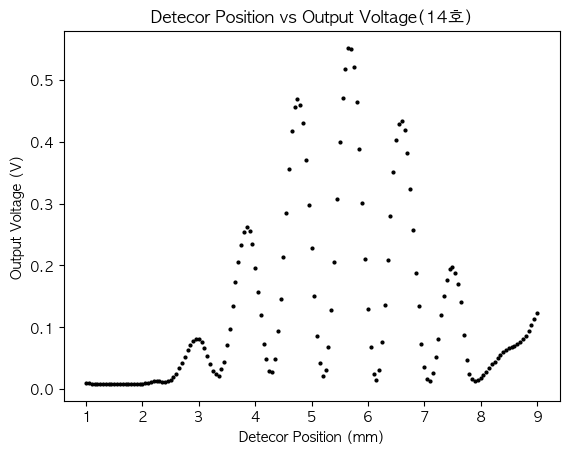

In [3]:
plot_data(14)

In [4]:
from LASER import *

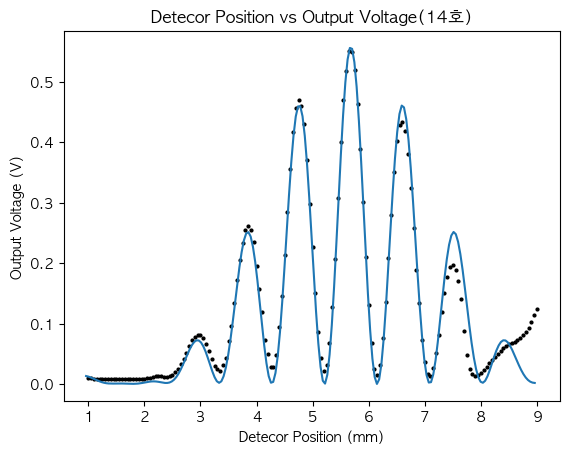

In [5]:
n = 200
center = 5.5e-3 * UNIT
detecor_pos = np.linspace(1e-3 * UNIT, 9e-3 * UNIT, n)
result = []
for pos in detecor_pos:
  result.append(simulate(center, 14, center, pos))
result = np.array(result)
result = np.array(result)
plt.plot(detecor_pos/UNIT * 1e3 - 0.04, result * 1e26 / 6.3)

plot_data(14)

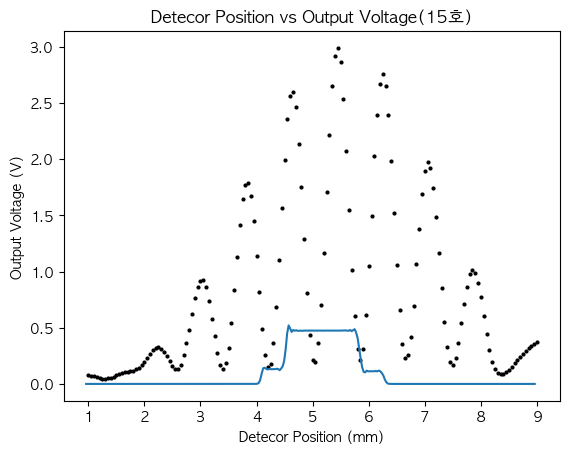

In [137]:
n = 300
center = 5e-3 * UNIT
detecor_pos = np.linspace(1e-3 * UNIT, 9e-3 * UNIT, n)
result = []
for pos in detecor_pos:
  result.append(simulate(center, 15, pos, center-0.5e-3 * UNIT))
result = np.array(result)
result = np.array(result)
plt.plot(detecor_pos/UNIT * 1e3 - 0.04, result * 1e26 / 6.3)
plot_data(15)

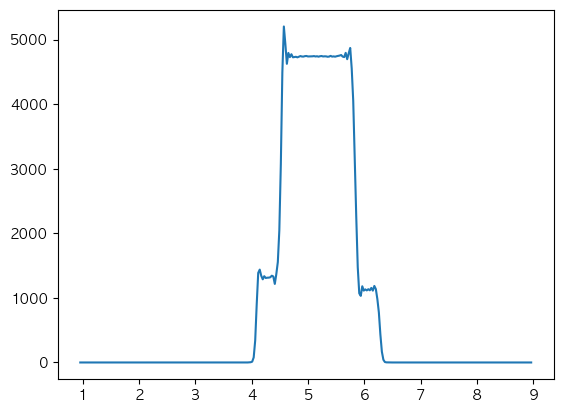

In [138]:
plt.plot(detecor_pos/UNIT * 1e3 - 0.04, result * 1e30 / 6.3)


/var/folders/nt/v94rk70j2kd3xsql3g__bt3r0000gn/T/ipykernel_27795/1516745023.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  plt.plot(x[plot_x], y[plot_x])


Text(0.05, 0.9, '$R^2=0.9789$')

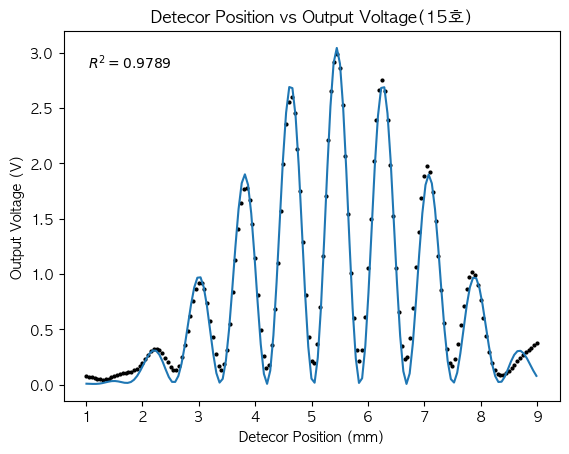

In [123]:
plot_data(15)
pos, volt = get_data(15)
x = (detecor_pos/UNIT * 1e3 - 0.95) * 1.13
y = result * 1e26 / 1.15
# filter x range
plot_x = np.logical_and(x > 1, x < 9)
plt.plot(x[plot_x], y[plot_x])
volt_pred = np.interp(pos, x, y)
diff = np.sum(np.square(volt_pred - volt))
R2 = 1 - diff / np.sum(np.square(volt - np.mean(volt)))
plt.title(f"Detecor Position vs Output Voltage(15호)")
plt.text(0.05, 0.9, f"$R^2={R2:.4f}$", fontsize=10, transform=plt.gca().transAxes)

In [82]:
import torch
from torch import Tensor
def interp(x: Tensor, xp: Tensor, fp: Tensor) -> Tensor:
    """One-dimensional linear interpolation for monotonically increasing sample
    points.

    Returns the one-dimensional piecewise linear interpolant to a function with
    given discrete data points :math:`(xp, fp)`, evaluated at :math:`x`.

    Args:
        x: the :math:`x`-coordinates at which to evaluate the interpolated
            values.
        xp: the :math:`x`-coordinates of the data points, must be increasing.
        fp: the :math:`y`-coordinates of the data points, same length as `xp`.

    Returns:
        the interpolated values, same size as `x`.
    """
    m = (fp[1:] - fp[:-1]) / (xp[1:] - xp[:-1])
    b = fp[:-1] - (m * xp[:-1])

    indicies = torch.sum(torch.ge(x[:, None], xp[None, :]), 1) - 1
    indicies = torch.clamp(indicies, 0, len(m) - 1)

    return m[indicies] * x + b[indicies]

/var/folders/nt/v94rk70j2kd3xsql3g__bt3r0000gn/T/ipykernel_27795/2267575696.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  detecor_pos = th.tensor(detecor_pos, device=device)
/var/folders/nt/v94rk70j2kd3xsql3g__bt3r0000gn/T/ipykernel_27795/2267575696.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = th.tensor(result, device=device)


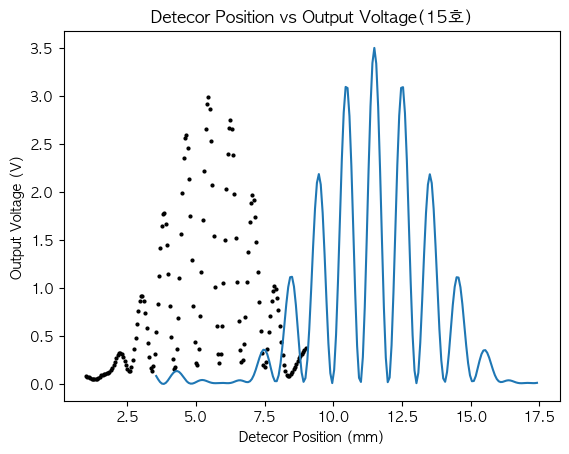

In [79]:
import torch as th
device = th.device('cpu')

a = th.tensor(0.0, device=device, requires_grad=True)
b = th.tensor(0.03, device=device, requires_grad=True)
c = th.tensor(26.0, device=device, requires_grad=True)

optimizer = th.optim.SGD([b], lr=0.01)

pos, volt = get_data(15)
pos = th.tensor(pos, device=device)
volt = th.tensor(volt, device=device)
detecor_pos = th.tensor(detecor_pos, device=device)
result = th.tensor(result, device=device)
m = 1.4
for i in range(100):
  optimizer.zero_grad()
  result_reindex = interp(pos, detecor_pos / UNIT * 1e3 * m - b, result * th.pow(10, c))
  loss = th.sum(th.square(volt - result_reindex))
  loss.backward()
  optimizer.step()

with th.no_grad():
  plt.plot(detecor_pos/UNIT * 1e3 * m - b, result * (10**c))
  plot_data(15)

In [71]:
b

tensor(0.7439, requires_grad=True)

In [17]:
volt, result_reindex

(tensor([0.0780, 0.0740, 0.0680, 0.0590, 0.0530, 0.0480, 0.0470, 0.0500, 0.0560,
         0.0660, 0.0760, 0.0890, 0.0970, 0.1040, 0.1090, 0.1140, 0.1190, 0.1290,
         0.1450, 0.1670, 0.1960, 0.2320, 0.2690, 0.3020, 0.3210, 0.3260, 0.3140,
         0.2850, 0.2440, 0.2020, 0.1600, 0.1340, 0.1360, 0.1720, 0.2540, 0.3600,
         0.4840, 0.6200, 0.7600, 0.8630, 0.9200, 0.9210, 0.8640, 0.7420, 0.5790,
         0.4290, 0.2760, 0.1700, 0.1340, 0.1840, 0.3170, 0.5450, 0.8340, 1.1270,
         1.4120, 1.6450, 1.7730, 1.7830, 1.6690, 1.4520, 1.1420, 0.8150, 0.4930,
         0.2600, 0.1540, 0.1810, 0.3630, 0.6870, 1.1010, 1.5670, 1.9910, 2.3530,
         2.5580, 2.5980, 2.4600, 2.1350, 1.7510, 1.2920, 0.8110, 0.4350, 0.2170,
         0.1940, 0.3650, 0.7050, 1.1660, 1.7080, 2.2160, 2.6540, 2.9140, 2.9890,
         2.8670, 2.5310, 2.0720, 1.5430, 1.0100, 0.6050, 0.3120, 0.2140, 0.3150,
         0.6090, 1.0530, 1.4960, 2.0270, 2.3920, 2.6670, 2.7550, 2.6540, 2.3890,
         1.9830, 1.5230, 1.0

In [11]:
def loss(slit_type, a, b, c, detecor_pos, result):
  pos, volt = get_data(slit_type)
  detecor_pos = th.tensor(detecor_pos) / UNIT * a - b
  result = th.tensor(result) * c
  for p in pos:
    if p < detecor_pos[0] or p > detecor_pos[-1]:
      print("out of range")
      return th.tensor(1e6)
  result = np.interp(pos, detecor_pos, result)
  return th.mean(th.pow(result - volt, 2))

In [12]:
th.nn.functional.interpolate()

TypeError: interpolate() missing 1 required positional argument: 'input'

In [ ]:
loss(15, a, b, c, detecor_pos, result)

out of range


tensor(1000000.)